In [2]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.cluster import KMeans, spectral_clustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from copy import deepcopy


In [3]:
os.chdir("/home/g.esposito/sc2-benchmark")
path = os.getcwd()

log_folders = [file_path for file_path in os.listdir("/home/g.esposito/sc2-benchmark") if "L" in file_path and file_path != "LICENSE"]
# print(log_folders)

general_report = pd.DataFrame([])
for layer_conf in log_folders:
    if layer_conf != ".DS_Store":
        folder_path = os.path.join(path,  layer_conf)
        for cnf in [files for files in os.listdir(folder_path) if files != ".DS_Store"]:
            file_path = os.path.join(folder_path, cnf)

            report_path = os.path.join(file_path, "fsim_full_report.csv")
            report = pd.read_csv(report_path)
            report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
            # print(report.columns)
            report['bit_faulty_position'] = np.log2(report['bitmask'])
            report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)

            indices = report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0").index
            for idx in indices:
                report.loc[idx, 'boxes_Crit'] = report.loc[idx, 'average_golden_boxes']*100

            tot_boxes_per_fault = report['boxes_Crit'] + report['boxes_SDC'] + report['boxes_Masked']
            # for val in tot_boxes_per_fault:
            #     if val == 0:
            #         print('queste sono tutte critiche')
            report['Crit_perc'] = (report['boxes_Crit'] / tot_boxes_per_fault)*100
            report['SDC_perc'] = (report['boxes_SDC'] / tot_boxes_per_fault)*100
            report['masked_perc'] = (report['boxes_Masked'] / tot_boxes_per_fault)*100
            general_report = pd.concat([general_report, report], axis=0, ignore_index=True)
    

    # general_report.loc[indices]['Crit_perc'].fillna(1, inplace=True)
    # general_report.loc[indices,'SDC_perc'].fillna(0, inplace=True)
    # general_report.loc[indices,'masked_perc'].fillna(0, inplace=True)

# indices = general_report.query("boxes_Crit==0 and boxes_SDC==0 and boxes_Masked == 0")
# print(indices)

# general_report.shape
#(9130, 25)

In [6]:
general_report.isna().sum()
general_report.query("Crit_perc.isnull()")['conf_detail'].value_counts()

cnf3           41
cnf9           36
cnf6           34
cnf12          28
cnf2           26
cnf1           24
teacher_cnf    16
Name: conf_detail, dtype: int64

## Distribution Analysis
- layer
- kernel
- channel
- row
- col
- BitMask
- gold_iou: Intersection over Union score of the golden model for each num_layers compression
- boxes_Crit: most of the faults does not produce any critical fault and the faults that produce more than 10 critical boxes are only 7
- boxes_SDC: for each fault the number of SDC boxes are almost the same (around 517) which is very high that means that often the faults affect the model producing a slightly different result with respect to the golden model. 
- boxes_Masked: only in few cases the boxes predicted by the faulty model has perfectly masked boxes. Actually looking at the mean, we can see that all the faults, on average, 2 or 3 masked boxes (not that much) (remember that each fault is tested over 100 images).
- fault_iou@1: all the predicted boxes have iou score of 87% with respect to the boxes predicted by the golden model
- area_ratio: the same holds for the ratio between the ratio between the golden and faulty model (the number shows that the faulty tends to underestimate the area of the predicted boxes of, on average 12%)
- average_golden_boxes: The average number of bounding boxes over all the images of the dataset is 5.06
- average_faulty_boxes: The average number of bounding boxes over all the images of the dataset is 5.44 which is similar to the one of the golden model
- average_target_boxes: the expected number of boxes for each image is 7.78
- Ffree_Weight
- Faulty_weight
- Abs_error
- conf_detail: label of the configuration (let us try to use it for the clustering)

In [73]:
print(general_report['bitmask'].unique())
np.log2(general_report['bitmask'].unique())

[ 536870912   16777216    2097152  134217728    1048576    4194304
    8388608   33554432  268435456 1073741824   67108864 2147483648]


array([29., 24., 21., 27., 20., 22., 23., 25., 28., 30., 26., 31.])

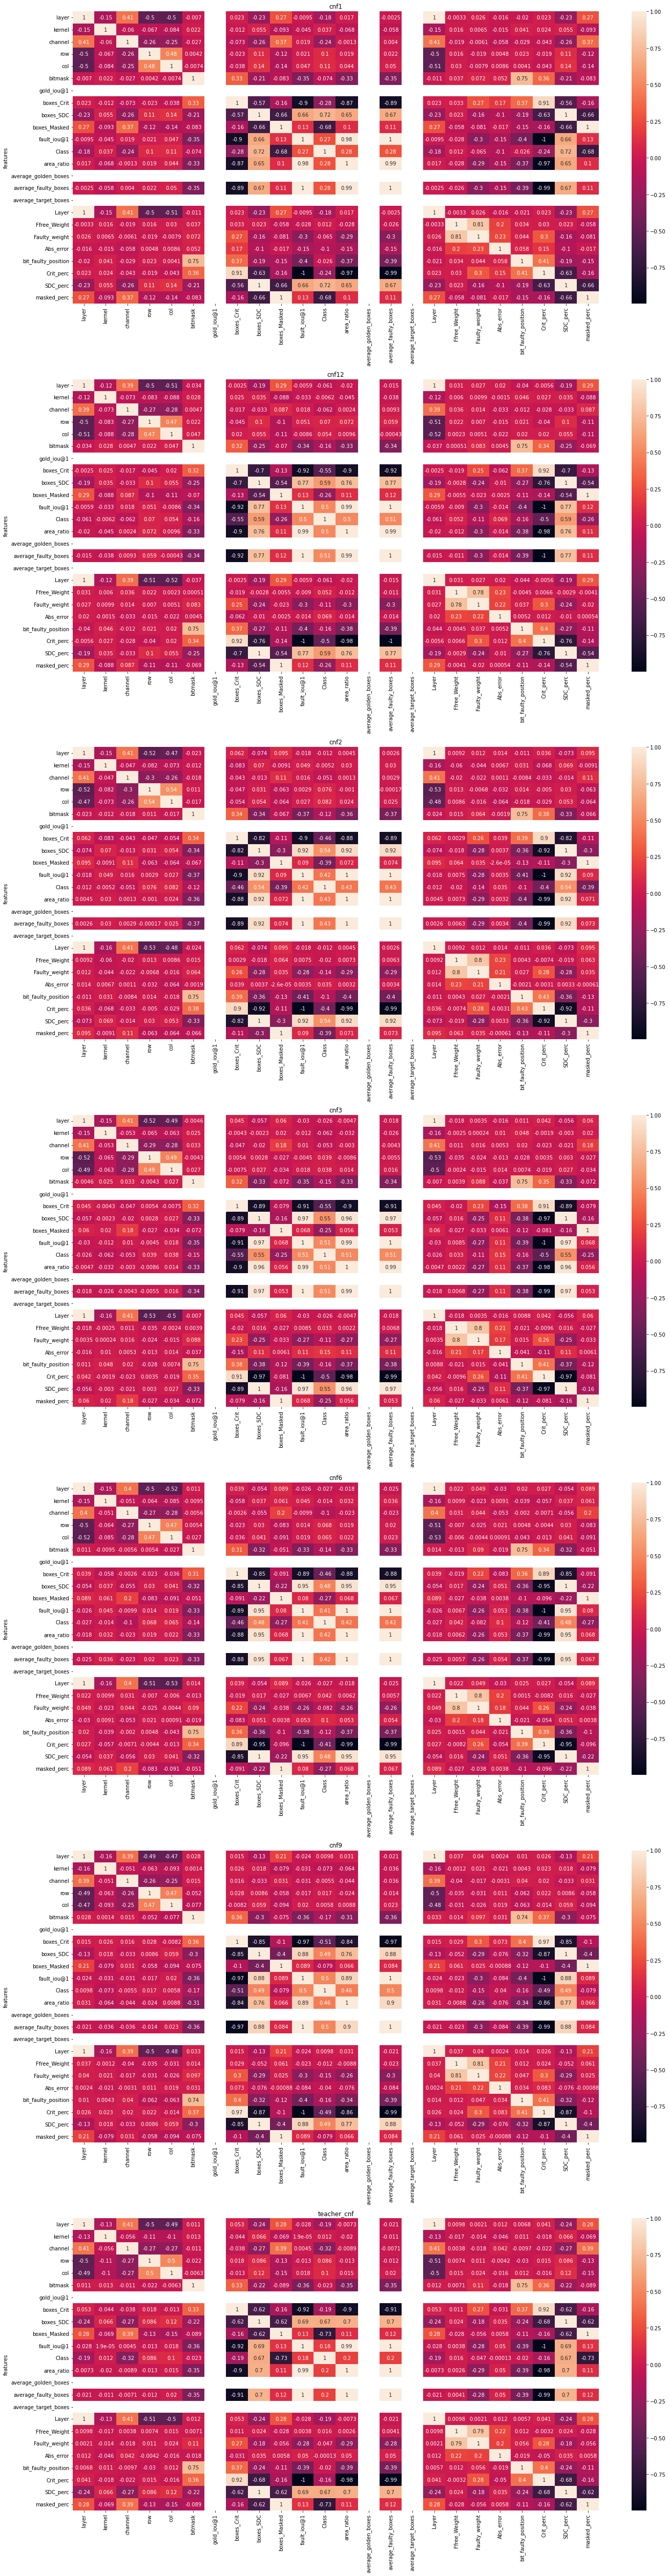

In [74]:
df_by_layer = general_report.groupby(by="conf_detail")

# for super_key, df in df_by_layer.groups.items():
#     print(super_key)
#     print(df)
corr_df = df_by_layer.corr()
fig, ax = plt.subplots(7,1, figsize=(20,70))
for i in range(len(list(df_by_layer.groups.keys()))):
    cnf = list(df_by_layer.groups.keys())[i]
    mini_corr_df = corr_df.loc[cnf, :]
    sns.heatmap(mini_corr_df,ax=ax[i], annot=True)
    ax[i].set_title(cnf)
    ax[i].set_ylabel("features")
plt.tight_layout()
    



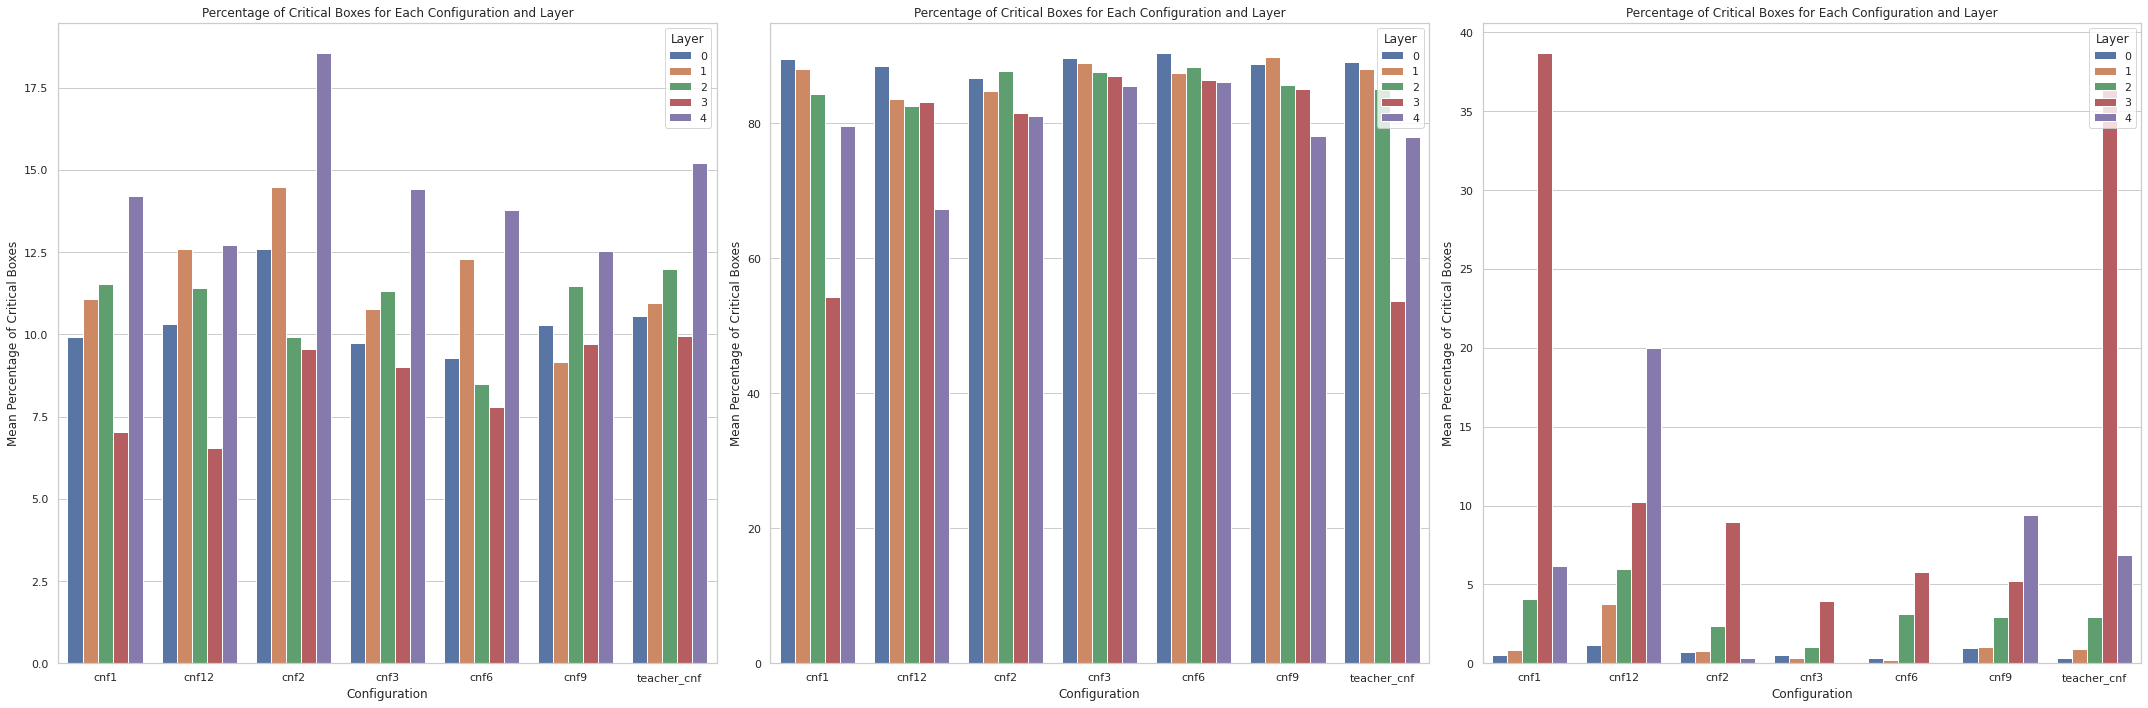

In [22]:
mean_percentages_crit = general_report.groupby(['conf_detail', 'layer'])['Crit_perc'].mean().reset_index()
mean_percentages_sdc = general_report.groupby(['conf_detail', 'layer'])['SDC_perc'].mean().reset_index()
mean_percentages_masked = general_report.groupby(['conf_detail', 'layer'])['masked_perc'].mean().reset_index()

fig, ax = plt.subplots(1,3, figsize=(30,10))
sns.set(style='whitegrid')
sns.barplot(x='conf_detail', y='Crit_perc', hue='layer', data=mean_percentages_crit, ax = ax[0])
ax[0].set_xlabel('Configuration')
ax[0].set_ylabel('Mean Percentage of Critical Boxes')
ax[0].set_title('Percentage of Critical Boxes for Each Configuration and Layer')
ax[0].legend(title='Layer', loc='upper right')

sns.set(style='whitegrid')
sns.barplot(x='conf_detail', y='SDC_perc', hue='layer', data=mean_percentages_sdc, ax = ax[1])
ax[1].set_xlabel('Configuration')
ax[1].set_ylabel('Mean Percentage of Critical Boxes')
ax[1].set_title('Percentage of Critical Boxes for Each Configuration and Layer')
ax[1].legend(title='Layer', loc='upper right')

sns.set(style='whitegrid')
sns.barplot(x='conf_detail', y='masked_perc', hue='layer', data=mean_percentages_masked, ax = ax[2])
ax[2].set_xlabel('Configuration')
ax[2].set_ylabel('Mean Percentage of Critical Boxes')
ax[2].set_title('Percentage of Critical Boxes for Each Configuration and Layer')
ax[2].legend(title='Layer', loc='upper right')
plt.tight_layout()


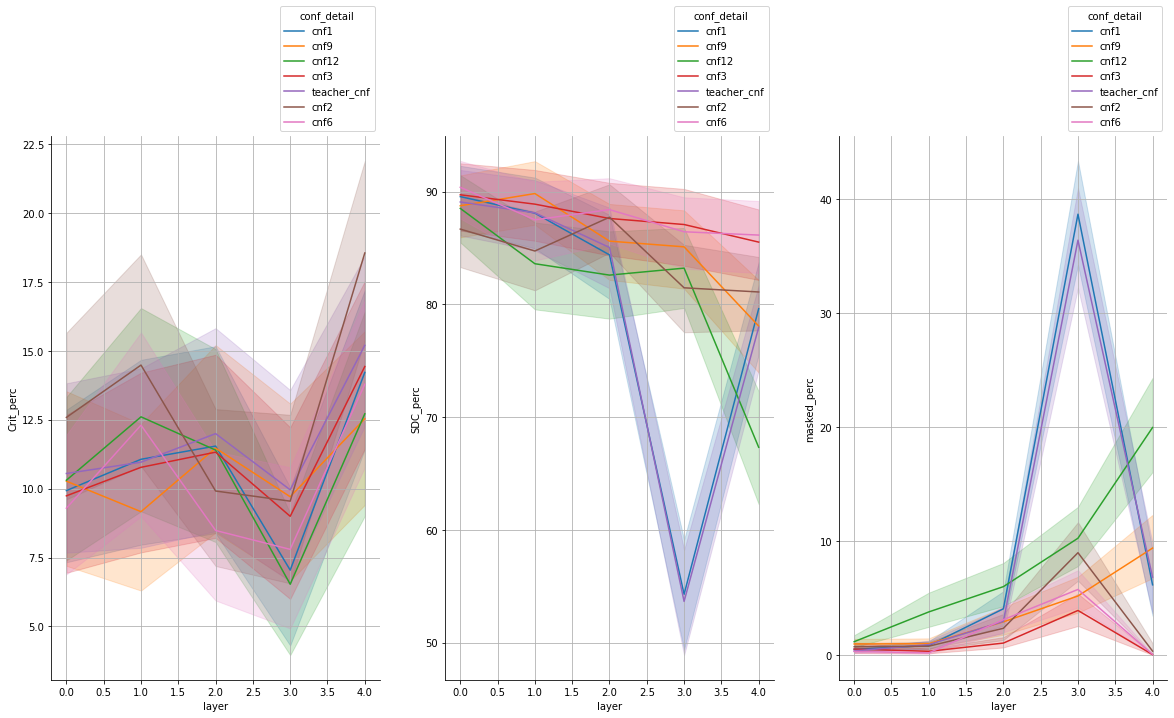

In [75]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='layer', y='Crit_perc', ax=ax[0], hue ='conf_detail')
sns.move_legend(ax[0], "lower right", bbox_to_anchor=(1, 1))
ax[0].grid()
sns.lineplot(data=general_report, x='layer', y='SDC_perc', ax=ax[1],hue ='conf_detail')
sns.move_legend(ax[1], "lower right", bbox_to_anchor=(1, 1))
ax[1].grid()
sns.lineplot(data=general_report, x='layer', y='masked_perc', ax=ax[2], hue ='conf_detail')
sns.move_legend(ax[2], "lower right", bbox_to_anchor=(1, 1))
ax[2].grid()


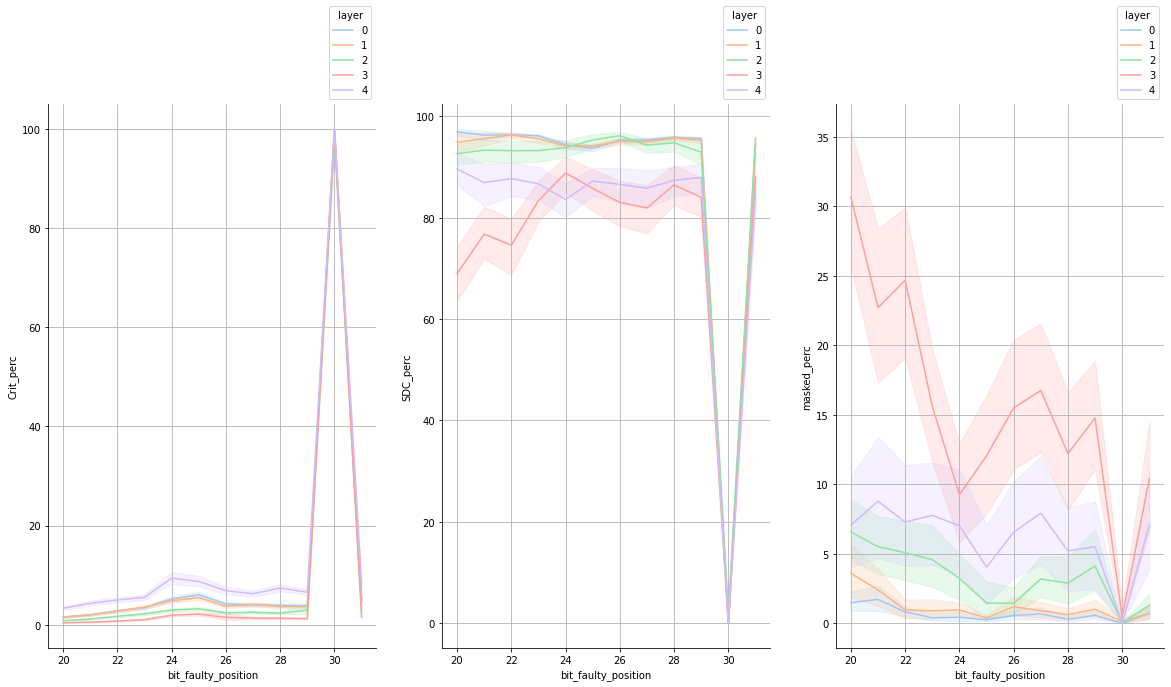

In [7]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='bit_faulty_position', y='Crit_perc', ax=ax[0], hue ='layer', palette='pastel')
sns.move_legend(ax[0], "lower right", bbox_to_anchor=(1, 1))
ax[0].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='SDC_perc', ax=ax[1],hue ='layer', palette='pastel')
sns.move_legend(ax[1], "lower right", bbox_to_anchor=(1, 1))
ax[1].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='masked_perc', ax=ax[2], hue ='layer', palette='pastel')
sns.move_legend(ax[2], "lower right", bbox_to_anchor=(1, 1))
ax[2].grid()

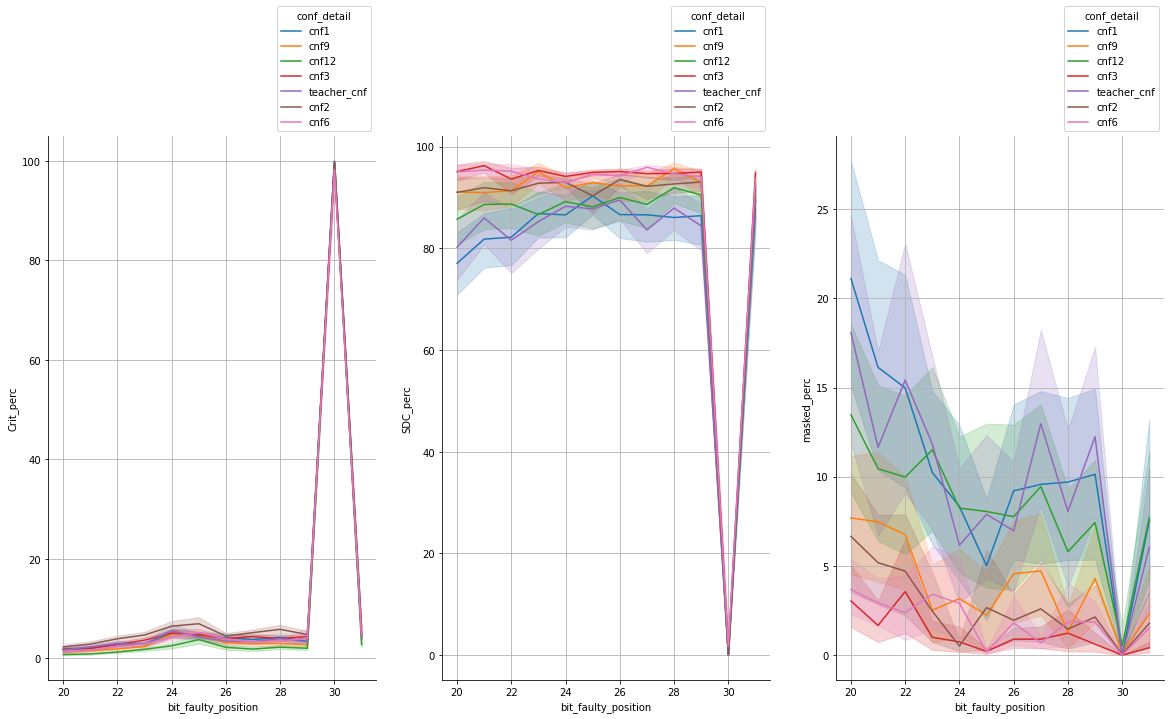

In [9]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='bit_faulty_position', y='Crit_perc', ax=ax[0], hue ='conf_detail')
sns.move_legend(ax[0], "lower right", bbox_to_anchor=(1, 1))
ax[0].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='SDC_perc', ax=ax[1],hue ='conf_detail')
sns.move_legend(ax[1], "lower right", bbox_to_anchor=(1, 1))
ax[1].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='masked_perc', ax=ax[2], hue ='conf_detail')
sns.move_legend(ax[2], "lower right", bbox_to_anchor=(1, 1))
ax[2].grid()


## Results:
- how the SDC should be interpreted? because the reasons why records are labeled as SDC are different. 

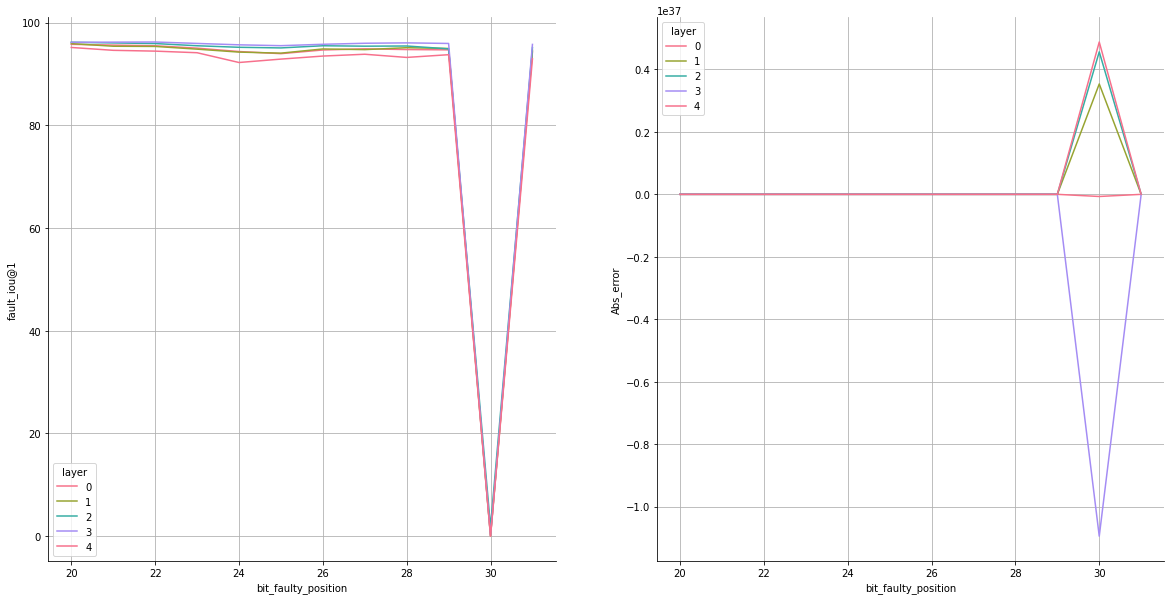

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='bit_faulty_position', y='fault_iou@1', ax=ax[0], hue ='layer', palette="husl", ci=None)
ax[0].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='Abs_error', ax=ax[1], hue ='layer', palette="husl", ci=None)
ax[1].grid()

In [65]:
general_report[general_report['bitmask'] == 1073741824]

,layer,kernel,channel,row,col,bitmask,gold_iou@1,boxes_Crit,boxes_SDC,boxes_Masked,...,average_target_boxes,Layer,Ffree_Weight,Faulty_weight,Abs_error,conf_detail,bit_faulty_position,Crit_perc,SDC_perc,masked_perc
24,4,0,2,1,0,1073741824,68.352722,0.0,0.0,0.0,...,7.78,4.0,3.196830e+09,4.270571e+09,9.287922e+37,cnf1,30.0,NaN,NaN,NaN
37,4,0,50,1,1,1073741824,68.352722,505.0,0.0,0.0,...,7.78,4.0,3.197911e+09,4.271652e+09,1.038419e+38,cnf1,30.0,100.000000,0.000000,0.0
71,4,0,15,1,1,1073741824,68.352722,505.0,0.0,0.0,...,7.78,4.0,3.192518e+09,4.266260e+09,6.711202e+37,cnf1,30.0,100.000000,0.000000,0.0
84,4,0,56,0,1,1073741824,68.352722,505.0,0.0,0.0,...,7.78,4.0,3.156294e+09,4.230036e+09,3.348581e+36,cnf1,30.0,100.000000,0.000000,0.0
103,4,0,15,0,0,1073741824,68.352722,505.0,0.0,0.0,...,7.78,4.0,3.190242e+09,4.263984e+09,5.557319e+37,cnf1,30.0,100.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9261,2,202,18,0,0,1073741824,69.731888,604.0,0.0,0.0,...,7.78,2.0,1.017182e+09,2.090924e+09,-6.686367e+36,cnf6,30.0,100.000000,0.000000,0.0
9268,2,145,11,1,1,1073741824,69.731888,16.0,0.0,0.0,...,7.78,2.0,1.040689e+09,2.114431e+09,-4.507905e+37,cnf6,30.0,100.000000,0.000000,0.0
9273,2,62,25,0,1,1073741824,69.731888,16.0,0.0,0.0,...,7.78,2.0,3.178142e+09,4.251884e+09,1.982183e+37,cnf6,30.0,100.000000,0.000000,0.0
9334,2,142,16,0,0,1073741824,69.731888,0.0,0.0,0.0,...,7.78,2.0,3.197539e+09,4.271281e+09,1.000712e+38,cnf6,30.0,NaN,NaN,NaN


In [15]:
to_melt = general_report[['layer','SDC_perc', 'Crit_perc', 'masked_perc']]
df_melted = to_melt.melt(id_vars='layer', var_name='box_type', value_name='box_perc')

In [16]:
# print(df_melted[df_melted['box_perc']==0]['layer'].value_counts())

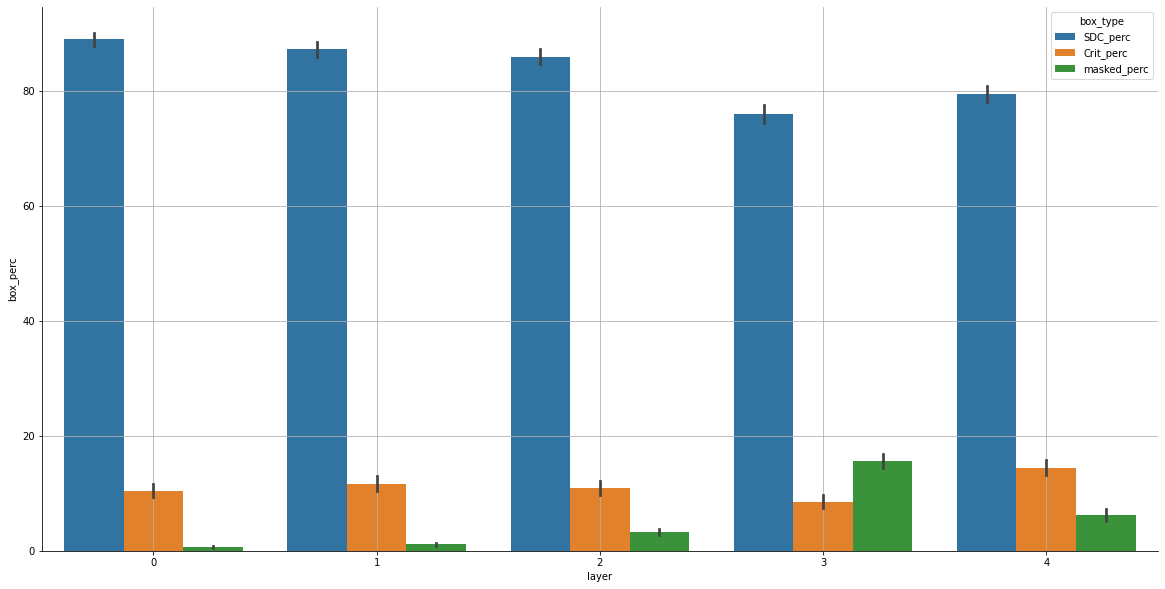

In [17]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.barplot(x='layer', y='box_perc', hue='box_type', data=df_melted, ax=ax)
ax.grid()
# ax.set_yscale('log')

The percentage of critical boxes over all the predicted ones have an almost stable trend. On the other hand, the percentage of masked boxes have a slight increasing trend. 

## Clustering

In [65]:
general_report

,layer,kernel,channel,row,col,bitmask,gold_iou@1,boxes_Crit,boxes_SDC,boxes_Masked,...,average_target_boxes,Layer,Ffree_Weight,Faulty_weight,Abs_error,conf_detail,bit_faulty_position,Crit_perc,SDC_perc,masked_perc
0,0,55,2,0,0,1073741824,68.310318,0,0,0,...,7.78,0.0,1.068061e+09,2.141802e+09,NaN,cnf1,30.0,0.000000,0.000000,0.000000
1,0,7,1,5,6,2097152,68.310318,1,505,0,...,7.78,0.0,3.205382e+09,3.207479e+09,0.125000,cnf1,21.0,0.197628,99.802372,0.000000
2,0,0,1,5,0,67108864,68.310318,2,504,0,...,7.78,0.0,1.042953e+09,9.758441e+08,0.165561,cnf1,26.0,0.395257,99.604743,0.000000
3,0,30,0,0,2,16777216,68.310318,5,499,1,...,7.78,0.0,3.197474e+09,3.214252e+09,0.876488,cnf1,24.0,0.990099,98.811881,0.198020
4,0,58,0,4,1,4194304,68.310318,0,504,2,...,7.78,0.0,3.193468e+09,3.189274e+09,-0.062500,cnf1,22.0,0.000000,99.604743,0.395257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,0,48,0,4,3,2147483648,69.619514,4,572,0,...,7.78,0.0,3.199081e+09,1.051597e+09,-0.680080,cnf3,31.0,0.694444,99.305556,0.000000
1879,0,38,2,6,1,1048576,69.619514,4,573,0,...,7.78,0.0,3.195604e+09,3.194555e+09,-0.015625,cnf3,20.0,0.693241,99.306759,0.000000
1880,0,43,2,1,4,134217728,69.619514,1,575,0,...,7.78,0.0,3.188815e+09,3.054598e+09,-0.142049,cnf3,27.0,0.173611,99.826389,0.000000
1881,0,39,1,6,1,536870912,69.619514,5,571,0,...,7.78,0.0,3.181916e+09,2.645045e+09,-0.082118,cnf3,29.0,0.868056,99.131944,0.000000


In [66]:
general_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask', 'gold_iou@1',
       'boxes_Crit', 'boxes_SDC', 'boxes_Masked', 'fault_iou@1', 'Class',
       'area_ratio', 'average_golden_boxes', 'average_faulty_boxes',
       'average_target_boxes', 'Layer', 'Ffree_Weight', 'Faulty_weight',
       'Abs_error', 'conf_detail', 'bit_faulty_position', 'Crit_perc',
       'SDC_perc', 'masked_perc'],
      dtype='object')

In [19]:
clustering_df = general_report[['conf_detail', 'fault_iou@1', 'bit_faulty_position', 'area_ratio', 'layer']]

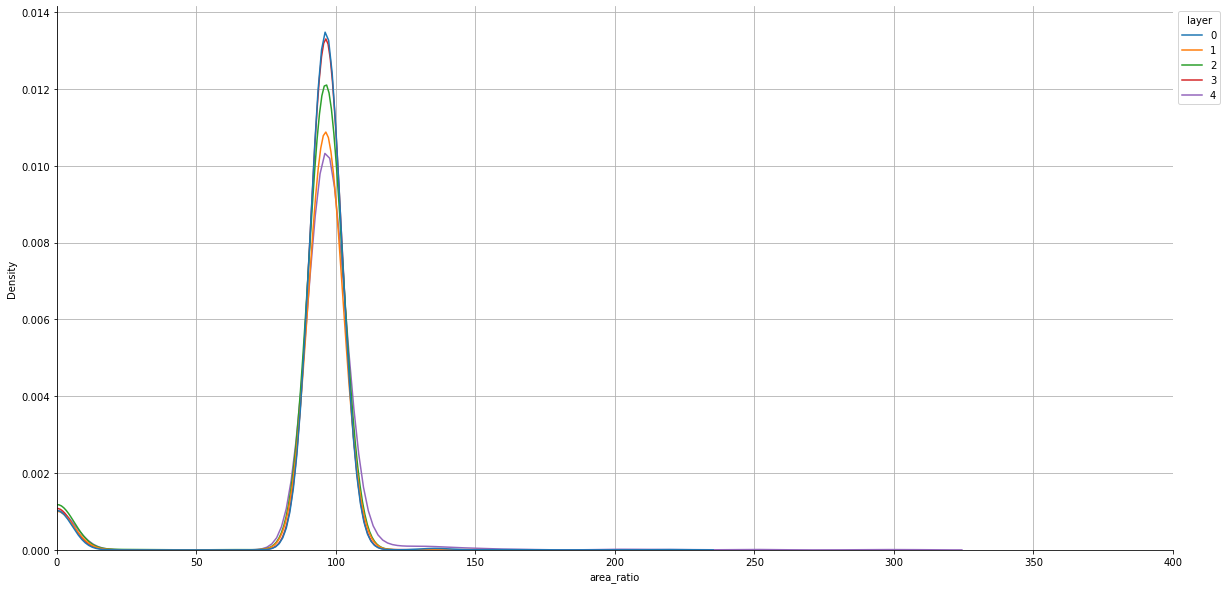

In [23]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.kdeplot(x = 'area_ratio', data=clustering_df, hue = 'layer', palette="tab10")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0, 400)
ax.grid()

(0.0, 100.0)

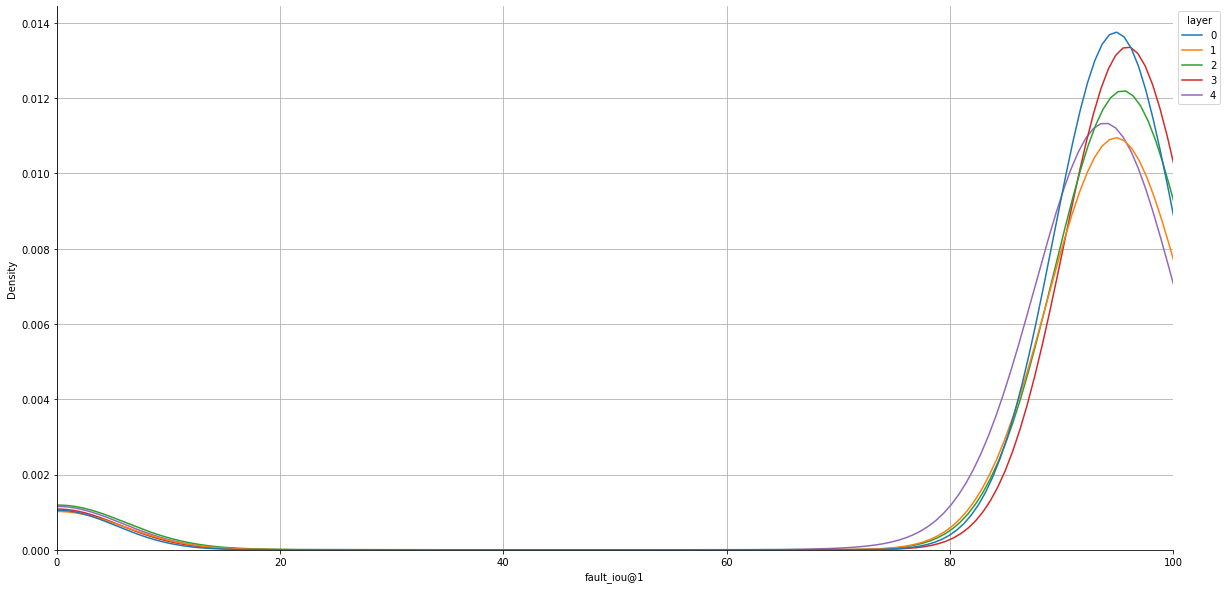

In [26]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.kdeplot(x = 'fault_iou@1', data=clustering_df, hue = 'layer', palette="tab10")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.grid()
ax.set_xlim(0, 100)

In [28]:
kmeans = KMeans(
    init="random",
    n_init=10,
    max_iter=300,
    random_state=42
)

In [92]:

clustering_df.dropna(inplace=True)
scaled_clustering_df = deepcopy(clustering_df)

scaler = MinMaxScaler(feature_range = (0,1))

scaled_clustering_df.loc[:,['fault_iou@1', 'bit_faulty_position', 'area_ratio']] = scaler.fit_transform(clustering_df[['fault_iou@1', 'bit_faulty_position', 'area_ratio']])
valuable_clustering_df = scaled_clustering_df[scaled_clustering_df['fault_iou@1'] != 0]

print(valuable_clustering_df.describe())

/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


       fault_iou@1  bit_faulty_position   area_ratio        layer
count  8450.000000          8450.000000  8450.000000  8450.000000
mean      0.967493             0.463400     0.317171     2.002604
std       0.044312             0.301394     0.022818     1.416970
min       0.009179             0.000000     0.003018     0.000000
25%       0.958618             0.181818     0.312348     1.000000
50%       0.969388             0.454545     0.315241     2.000000
75%       0.982909             0.727273     0.321332     3.000000
max       1.000000             1.000000     1.000000     4.000000


In [93]:
valuable_clustering_df = clustering_df[clustering_df['fault_iou@1'] > 0]
valuable_clustering_df[clustering_df['fault_iou@1'] < 50]

<ipython-input-93-ccf67d84eeda>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valuable_clustering_df[clustering_df['fault_iou@1'] < 50]


,conf_detail,fault_iou@1,bit_faulty_position,area_ratio,layer
4322,cnf12,10.000000,30.0,10.000000,1
4432,cnf12,1.000000,30.0,1.000000,1
5667,cnf1,3.000000,30.0,3.000000,3
5996,cnf9,14.000000,30.0,14.000000,3
6268,cnf12,6.000000,30.0,6.000000,3
7665,cnf1,5.893071,30.0,6.047192,2
8018,cnf9,1.984768,30.0,2.015560,2
8110,cnf12,0.918898,30.0,0.918898,2
8345,cnf3,27.384996,30.0,27.657593,2
8372,cnf3,1.000000,30.0,1.000000,2


/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.5803737109169912


No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3 The average silhouette_score is : 0.5137989175287583


No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.5495213771107781


No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.6047173883629996


No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.626805725295282


No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7 The average silhouette_score is : 0.6568517878906069


No handles with labels found to put in legend.
No handles with labels found to put in legend.


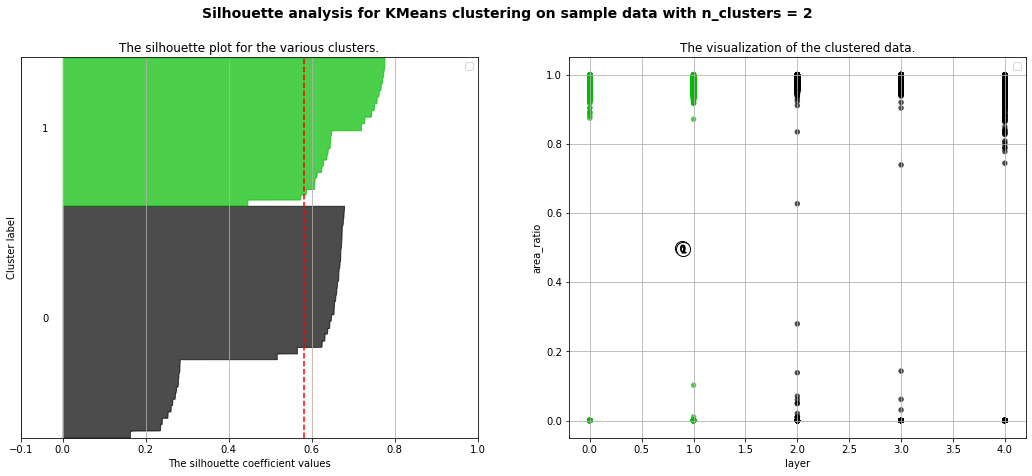

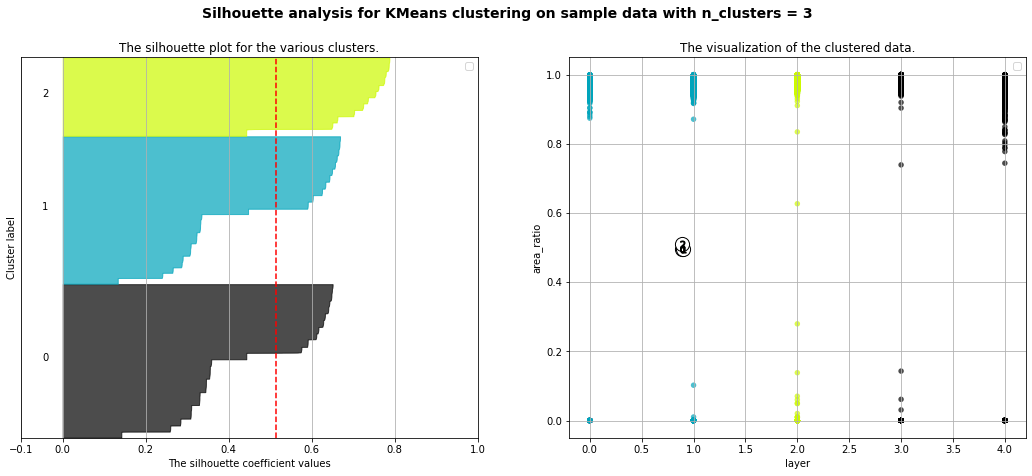

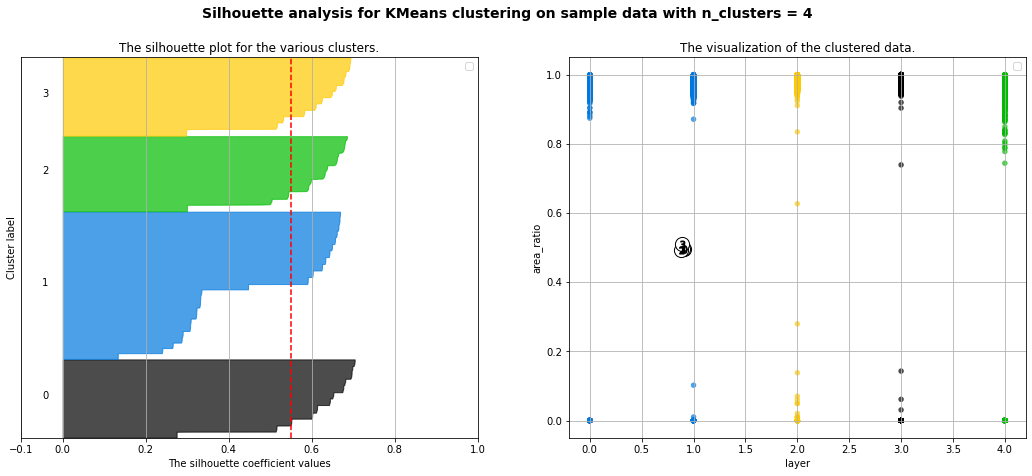

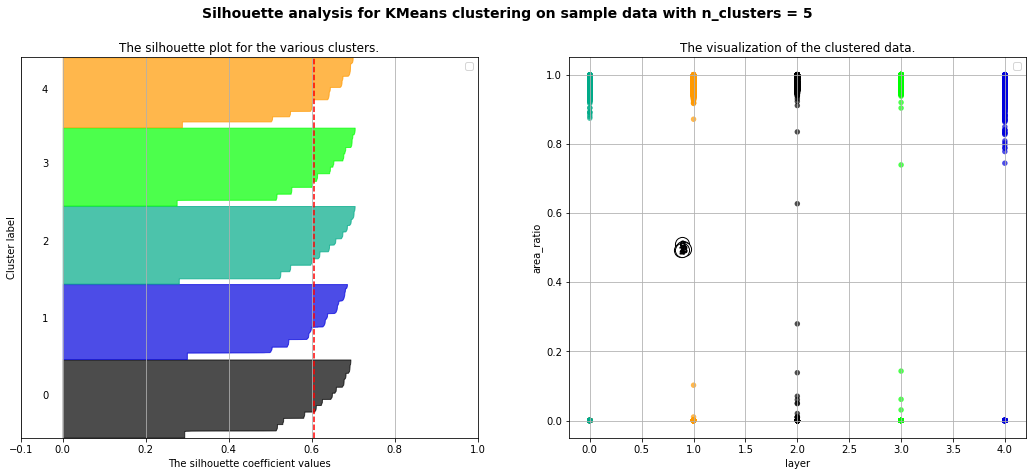

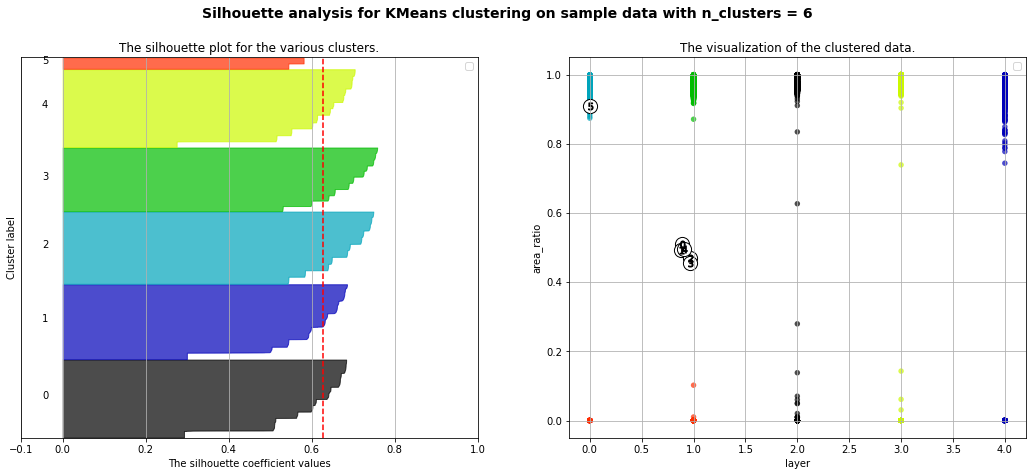

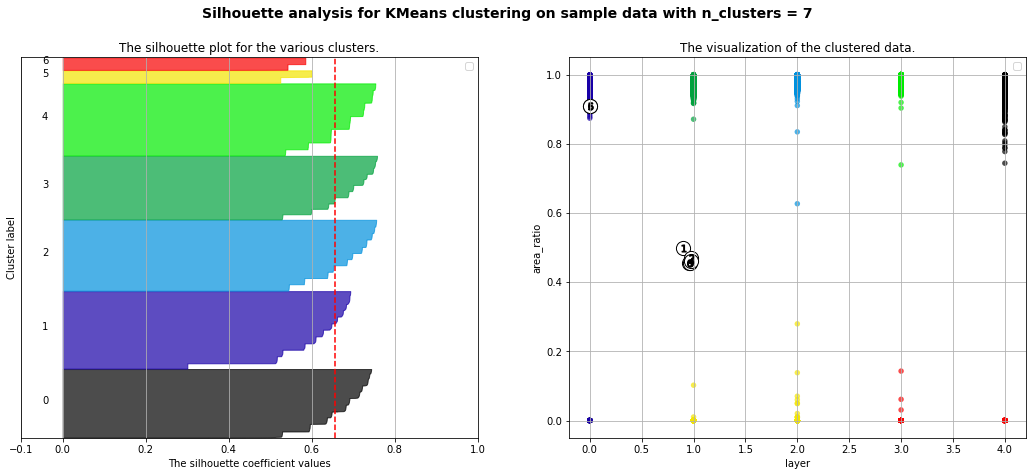

In [88]:
for n_clusters in range(2,8):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaled_clustering_df[['area_ratio', 'layer']]) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    # y_predicted = clusterer.fit_predict(scaled_clustering_df[['area_ratio', 'layer']])
    y_predicted = clusterer.fit_predict(scaled_clustering_df.iloc[:,1:])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # silhouette_avg = silhouette_score(scaled_clustering_df[['area_ratio', 'layer']], y_predicted)
    silhouette_avg = silhouette_score(scaled_clustering_df.iloc[:,1:], y_predicted)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    # Compute the silhouette scores for each sample
    # sample_silhouette_values = silhouette_samples(scaled_clustering_df[['area_ratio', 'layer']], y_predicted)
    sample_silhouette_values = silhouette_samples(scaled_clustering_df.iloc[:,1:], y_predicted)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[y_predicted == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
         # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(y_predicted.astype(float) / n_clusters)
    ax2.scatter(
        scaled_clustering_df['layer'], scaled_clustering_df['fault_iou@1'], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("layer")
    ax2.set_ylabel("area_ratio")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    ax1.grid()
    ax1.legend()
    ax2.grid()
    ax2.legend()
    # ax2.set_yscale('log')

plt.show()

/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI): -3.655959983398688e-05


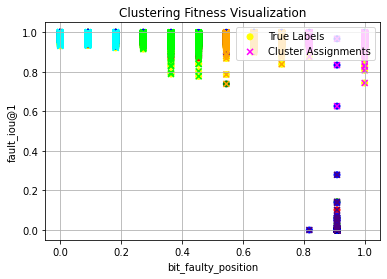

In [99]:
true_labels = scaled_clustering_df['layer']
secondary_labels = scaled_clustering_df['conf_detail']

# Drop the true labels column to prepare the data for clustering
X = scaled_clustering_df.drop(columns=['layer', 'conf_detail'])

# Apply K-means clustering with k=3 (number of clusters, you can adjust this)
n_clusters = len(true_labels.unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(X)

# Calculate the Adjusted Rand Index (ARI) to evaluate the clustering performance
ari = adjusted_rand_score(true_labels, cluster_assignments)
print(f"Adjusted Rand Index (ARI): {ari}")

# Create a color map for the true labels
label_colors = {1: 'red', 2: 'blue', 3:'green', 4:'yellow', 0:'purple'}

true_label_colors = [label_colors[label] for label in true_labels]

# Create a color map for the cluster assignments
cluster_colors = ['orange', 'indigo', 'cyan', 'magenta', 'lime']
cluster_assignment_colors = [cluster_colors[label] for label in cluster_assignments]

# Plot the data points with true labels and cluster assignments
plt.scatter(X['bit_faulty_position'], X['fault_iou@1'], c=true_label_colors, marker='o', label='True Labels')
plt.scatter(X['bit_faulty_position'], X['fault_iou@1'], c=cluster_assignment_colors, marker='x', label='Cluster Assignments')

# Add legend and labels
plt.legend(loc='upper right')
plt.xlabel('bit_faulty_position')
plt.ylabel('fault_iou@1')
plt.title('Clustering Fitness Visualization')
plt.grid(True)

plt.show()

